In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from scipy.signal import savgol_filter

from modes_func import *
from definition.defPrincipal import *

In [2]:
def adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        return ds
    

def addGrille(ds):
    # On récupère la liste des fichiers à ouvrir via le fichier liste 
    path = "../"
    gridname = path+'gigatl3_grid.nc'
    gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
    ds['hc'] = gd.hc
    ds['h'] = gd.h
    # ds['Vtransform'] = gd.Vtransform
    ds['sc_r'] = gd.sc_r
    ds['sc_w'] = gd.sc_w
    ds['Cs_r'] = gd.Cs_r
    ds['Cs_w'] = gd.Cs_w
    ds['angle'] = gd.angle
    ds['mask_rho'] = gd.mask_rho

    # On modifie des dimensions et des coordonnées, on crée la grille xgcm
    ds = adjust_grid(ds)
    L = ds.dims['x_rho']
    M = ds.dims['y_rho']
    N = ds.dims['s_rho']

    # On crée la grille xgcm
    ds = xgcm_grid(ds)
    grid = ds.attrs['xgcm-Grid']
    return ds, grid

    
def xgcm_grid(ds):
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [3]:
exp = 'bvf_GIGATL3'
indir = '../'
infile = indir+exp+'.nc'
ds = xr.open_dataset(infile)
# ds = ds.isel(time_counter = 0)

# data = data.sel(x_rho = slice(-40,-20), y_rho = slice(-2.5,2.5))
# data = data.sel(time=slice("2009-10-01","2010-07-01"))

dsZeta = xr.open_dataset('../zeta_GIGATL3.nc')
# dsZeta = dsZeta.isel(time_counter = 0)
# ds['zeta'] = dsZeta.zeta.values
ds, grid = addGrille(ds)
dsZeta, grid = addGrille(dsZeta)
ds['Vtransform'] = 2

dsZeta = dsZeta.isel(time_counter = 0, x_rho = slice(0,None,2), y_rho = slice(0,None,2))
ds = ds.isel(time_counter = 0, x_rho = slice(0,None,2), y_rho = slice(0,None,2))
ds

<xarray.Dataset>
Dimensions:        (s_rho: 100, s_w: 101, x_rho: 1501, y_rho: 2001)
Coordinates:
    eta_w          (y_rho, x_rho) float32 ...
    xi_w           (y_rho, x_rho) float32 ...
  * s_w            (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.02 -0.01 0.0
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2010-07-05T23:44:37.023411456
    eta_rho        (y_rho, x_rho) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    xi_rho         (y_rho, x_rho) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
  * s_rho          (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
Dimensions without coordinates: x_rho, y_rho
Data variables:
    bvf            (s_w, y_rho, x_rho) float32 ...
    hc             float32 300.0
    h              (y_rho, x_rho) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    sc_r           (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_w           (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    Cs_r           (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_w           (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    angle          (y_rho, x_rho) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    mask_rho       (y_rho, x_rho) float32 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    Vtransform     int64 2
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (periodic, boundary=None):\n  * center  ...

In [4]:
ds['Vtransform'] = 2


In [5]:
%%time
# Compute depth at rho point
z = get_z(ds,zeta=dsZeta['zeta'],hgrid='r').compute()

CPU times: user 15.4 s, sys: 4.72 s, total: 20.1 s
Wall time: 15.6 s


In [6]:
bvf=w2rho(ds.bvf,ds)


In [7]:
%%time
#plot slice latitude
latitude = 0.
vnew= slice2(ds,bvf,z, latitude=latitude)

CPU times: user 32 s, sys: 3.19 s, total: 35.2 s
Wall time: 48.1 s


In [8]:
yrho, xrho = findLatLonIndex(ds, -20.,0.)
print(yrho, xrho)

776 915


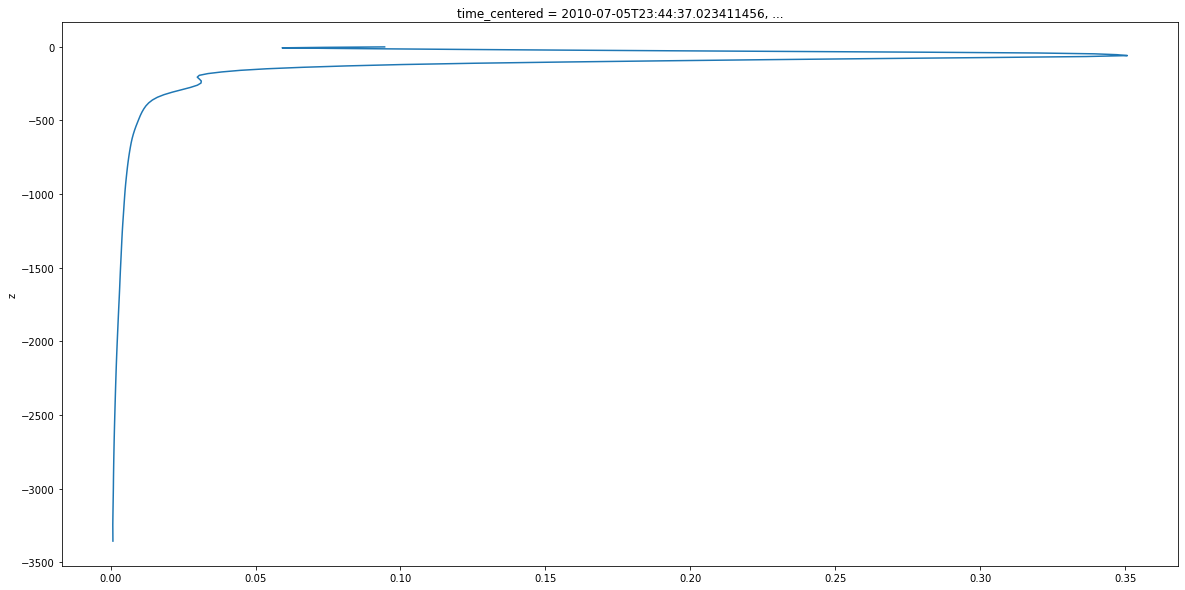

In [9]:
plt.figure(figsize=(20,10))
vnew2=vnew.isel(x_rho=xrho)*1e3
vnew2.plot(y='z')

In [10]:
ds = xr.open_dataset(infile)
ds = ds.isel(time_counter = 0, x_w = slice(0,None,2), y_w = slice(0,None,2))

In [11]:
ds.isel(x_w = 915 , y_w = 776)

<xarray.Dataset>
Dimensions:        (s_w: 101)
Coordinates:
    nav_lat_w      float32 ...
    nav_lon_w      float32 ...
  * s_w            (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.02 -0.01 0.0
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2010-07-05T23:44:37.023411456
Data variables:
    bvf            (s_w) float32 ...

In [13]:
z.isel(y_rho = yrho, x_rho=xrho)

<xarray.DataArray 'z_r' (s_rho: 100)>
array([-3.23206152e+03, -3.17963379e+03, -3.12496948e+03, -3.06821655e+03,
       -3.00953540e+03, -2.94909692e+03, -2.88708032e+03, -2.82367114e+03,
       -2.75905737e+03, -2.69342993e+03, -2.62697778e+03, -2.55988867e+03,
       -2.49234595e+03, -2.42452783e+03, -2.35660620e+03, -2.28874487e+03,
       -2.22109961e+03, -2.15381665e+03, -2.08703394e+03, -2.02087769e+03,
       -1.95546570e+03, -1.89090454e+03, -1.82729053e+03, -1.76471143e+03,
       -1.70324341e+03, -1.64295483e+03, -1.58390356e+03, -1.52614001e+03,
       -1.46970532e+03, -1.41463342e+03, -1.36095105e+03, -1.30867737e+03,
       -1.25782617e+03, -1.20840479e+03, -1.16041541e+03, -1.11385547e+03,
       -1.06871753e+03, -1.02499109e+03, -9.82661011e+02, -9.41709900e+02,
       -9.02117004e+02, -8.63859253e+02, -8.26911804e+02, -7.91247681e+02,
       -7.56838745e+02, -7.23655212e+02, -6.91666687e+02, -6.60841858e+02,
       -6.31148926e+02, -6.02555603e+02, -5.75029297e+02, -5.48537842e+02,
       -5.23048584e+02, -4.98529449e+02, -4.74948456e+02, -4.52274109e+02,
       -4.30475311e+02, -4.09521637e+02, -3.89383148e+02, -3.70030670e+02,
       -3.51435638e+02, -3.33570282e+02, -3.16407562e+02, -2.99921265e+02,
       -2.84085968e+02, -2.68877136e+02, -2.54270905e+02, -2.40244370e+02,
       -2.26775467e+02, -2.13842941e+02, -2.01426361e+02, -1.89506134e+02,
       -1.78063477e+02, -1.67080429e+02, -1.56539841e+02, -1.46425323e+02,
       -1.36721252e+02, -1.27412796e+02, -1.18485886e+02, -1.09927147e+02,
       -1.01723923e+02, -9.38643188e+01, -8.63370743e+01, -7.91316376e+01,
       -7.22381058e+01, -6.56472778e+01, -5.93505287e+01, -5.33398857e+01,
       -4.76080246e+01, -4.21481895e+01, -3.69542503e+01, -3.20206413e+01,
       -2.73423958e+01, -2.29151077e+01, -1.87349434e+01, -1.47986298e+01,
       -1.11034365e+01, -7.64719534e+00, -4.42828131e+00, -1.44560957e+00],
      dtype=float32)
Coordinates:
    eta_rho        float32 0.01163
    xi_rho         float32 -20.01
    time_centered  datetime64[ns] 2010-07-05T23:44:37.023411456
    time_counter   datetime64[ns] 2010-07-05T23:44:37.023411456
    eta_w          float32 0.01163
    xi_w           float32 -20.01
  * s_rho          (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005

In [12]:
vnew2.z.values

array([-3.35589038e+03, -3.30138843e+03, -3.24455688e+03, -3.18555005e+03,
       -3.12453442e+03, -3.06168848e+03, -2.99719873e+03, -2.93125879e+03,
       -2.86406396e+03, -2.79581323e+03, -2.72670337e+03, -2.65693018e+03,
       -2.58668481e+03, -2.51615210e+03, -2.44551196e+03, -2.37493433e+03,
       -2.30458203e+03, -2.23460693e+03, -2.16515283e+03, -2.09635132e+03,
       -2.02832483e+03, -1.96118494e+03, -1.89503125e+03, -1.82995569e+03,
       -1.76603772e+03, -1.70334778e+03, -1.64194690e+03, -1.58188721e+03,
       -1.52321155e+03, -1.46595557e+03, -1.41014685e+03, -1.35580542e+03,
       -1.30294556e+03, -1.25157495e+03, -1.20169617e+03, -1.15330603e+03,
       -1.10639722e+03, -1.06095850e+03, -1.01697437e+03, -9.74426392e+02,
       -9.33293274e+02, -8.93550842e+02, -8.55173157e+02, -8.18132019e+02,
       -7.82398499e+02, -7.47941284e+02, -7.14728821e+02, -6.82728516e+02,
       -6.51907043e+02, -6.22230957e+02, -5.93666382e+02, -5.66179688e+02,
       -5.39736816e+02, -